In [82]:
import math
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, PhaseEstimation


Supongamos que tenemos un problema de búsqueda cuyas soluciones son los elementos que tienen imagen 1 por la función representada por la siguiente tabla de verdad:

| x_1 | x_2 | x_3 | y  |
| --- | --- | --- | ---|
| 0   | 0   | 0   | 0  |
| 0   | 0   | 1   | 0  |
| 0   | 1   | 0   | 0  |
| 0   | 1   | 1   | 0  |
| 1   | 0   | 0   | 0  |
| 1   | 0   | 1   | 1  |
| 1   | 1   | 0   | 0  |
| 1   | 1   | 1   | 1  |

A continución construimos el circuito que realiza la operación |x>|q> -> |x>|q XOR f(x)>. 

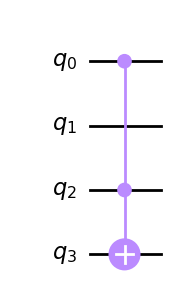

In [171]:
N = 8
M = 2


G = QuantumCircuit(3+1, name="G")

G.toffoli(0,2,3)



G.draw('mpl')

Ahora construimos la puerta que multiplica por -1 la amplitud de todos los estados distintos de |000>

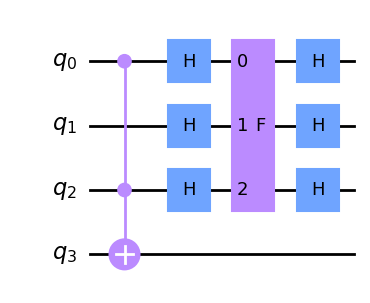

In [172]:
qc_fase = QuantumCircuit(3,name = "F")

p = []
for i in range(2**3):
    fila = [0 for j in range(2**3)]
    fila[i] = -1
    p.append(fila)
    
p[0][0] = 1

G.h(0)
G.h(1)
G.h(2)


qc_fase.append(Operator(p),[0,1,2])

G.append(qc_fase.to_gate(),[0,1,2])

G.h(0)
G.h(1)
G.h(2)

G.draw('mpl')

Este circuito conformará el operador de Grover G.

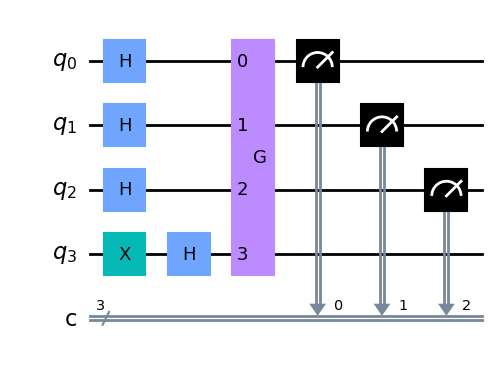

In [85]:
final_circ = QuantumCircuit(4,3)
final_circ.h(0)
final_circ.h(1)
final_circ.h(2)
final_circ.x(3)
final_circ.h(3)

R = int(math.pi/4*math.sqrt(N/M))

for i in range(R):
    final_circ.append(G.to_gate(),[0,1,2,3])
    
for i in range(3):
    final_circ.measure(i,i)

final_circ.draw('mpl')

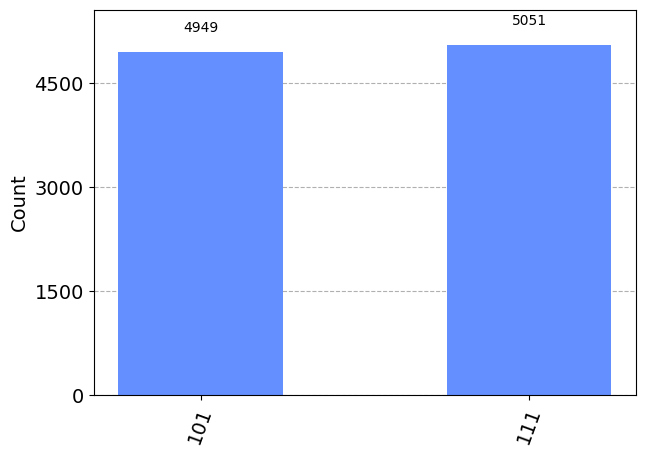

In [86]:
simulator = AerSimulator()
circuit_compiled = transpile(final_circ,simulator)
trabajo_sim = simulator.run(circuit_compiled, shots = 10000)
result = trabajo_sim.result()
counts = result.get_counts(circuit_compiled)

plot_histogram(counts)

Como podemos ver, el resultado son las entradas tal que la función tiene imagen uno y por tanto son soluciones del problema de búsqueda.

A continución usaremos el algoritmo de conteo para estimar M (número de soluciones). 

In [173]:
eps = 0.05 #Probabilidad de error deseada.
n = 4 # Número de bits de precisión.

m = 4 # Numero de qubits necesarios para la implementación del operador de Grover.

t = n + math.trunc(math.log(2+1/(2*eps))) 
if math.log(n+1/(2*eps)) - math.trunc(math.log(n+1/(2*eps))) != 0:
    t = t+1

t #Número de qubits de trabajo

7

Esta vez utilizaremos la implementación nativa de Qiskit del circuito de estimación de fase.

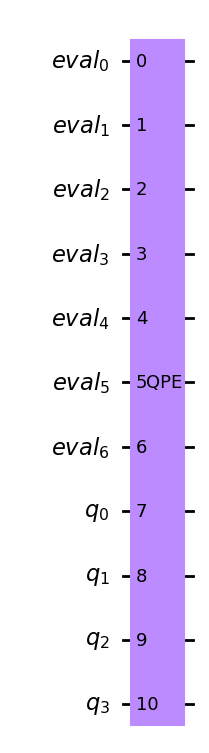

In [174]:
#Aquí, el operador cuyas fases de autovalores queremos estimar es claramente el operador de Grover, G.

pc = PhaseEstimation(t,G, iqft=None, name='QPE')
pc.draw('mpl')

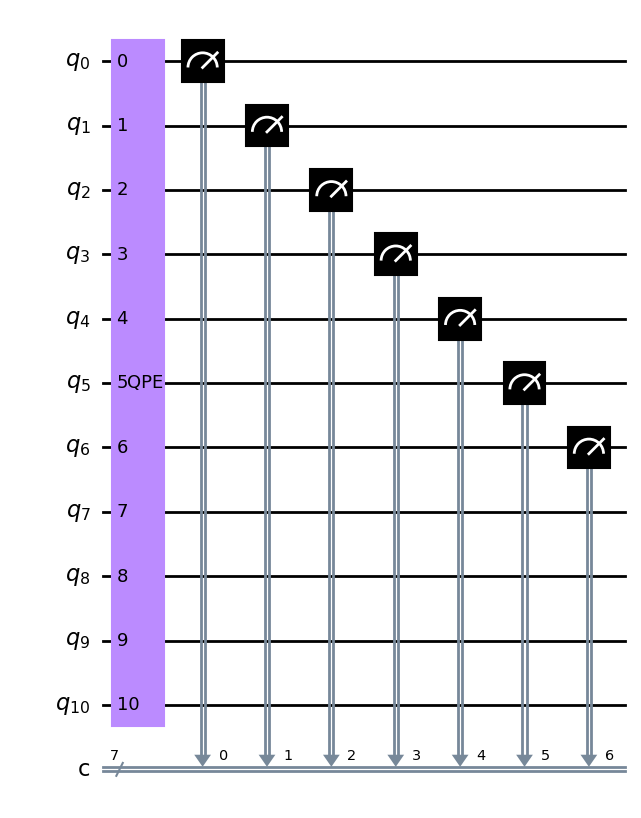

In [176]:
#Añadimos la medición.
pc_f = QuantumCircuit(t+m,t)
pc_f.append(pc.to_gate(),[i for i in range(t+m)])

for i in range(t):
    pc_f.measure(i,i)

pc_f.draw('mpl')

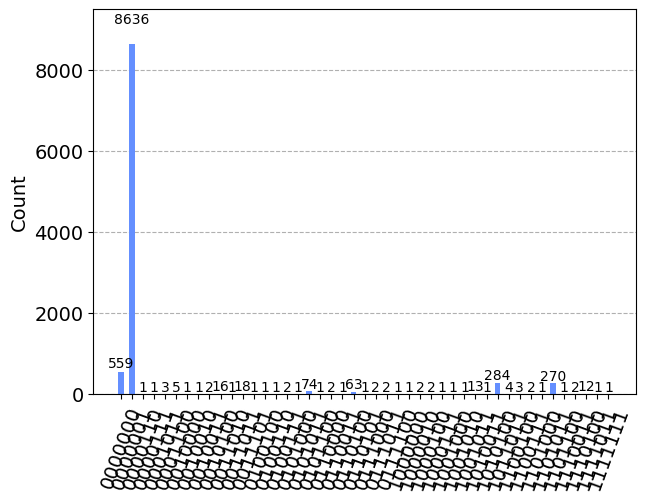

In [179]:
simulator = AerSimulator()
circuit_compiled = transpile(pc_f,simulator)
trabajo_sim = simulator.run(circuit_compiled, shots = 10000)
result = trabajo_sim.result()
counts = result.get_counts(circuit_compiled)

plot_histogram(counts)

Ahora debemos tener en cuenta que el algoritmo de estimación de false calcula phi tal que e^(2iPI phi) sea un autovalor, pero necesitamos calcular theta tal que e^(i theta) sea dicho autovalor. Es por esto que tenemos que calcular theta a partir de phi. 

In [180]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str)

theta = measured_int * 2*math.pi /2**t
theta

0.04908738521234052

A partir de theta podemos calcular M

In [169]:
N*(math.sin(theta/2))**2

2.0